# XY-calibration (F1)

In [1]:
cd ..

/home/jovyan


In [27]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit, coord_list_to_array
from Calibration.mapping import Mapping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## initialization from last xy calib
---------------------------------

In [3]:
# prerequisites:
Field = "F1"
# previous_xy_mapping = 'Notebook/Files/Guider2UV_%s_nogamma.new.pkl'%(Field)
previous_xy_mapping = 'Calibration/Mappings/2022/XY/%s_XY_prep.pkl'%(Field)
# mask_det_map_file = "Calibration/Mappings/2022/mapping-mask-det-w-2022-5-%s_center.pkl"%(Field)
mask_det_map_file = "Calibration/Mappings/2022/mapping_new_center/mapping-mask-det-w-2022-5-%s_-60.pkl"%(Field)
target_filename = 'Calibration/Targets/2022/targets_%s.txt'%(Field)
# mapping_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/%s/%s_2022_6_-82.fits"%(Field,Field)
# new_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/%s/%s_2022_6_-106.fits"%(Field,Field)
# encoder gains 2018:
# CEg = 1.02928
# Elg = 1.00379
# encoder gains 2022:
CEg = 1.0187
Elg = 1.0090
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09283 ''/inc and Ce is 0.01019 ''/inc


In [4]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)
print(G2UV)

## eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
# G2UV.mask_rotation = 0.0*u.arcmin
# G2UV.FieldP.gamma = 1. 

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)


# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    (0.1863709, -0.04835265)>
FOV center pixel position in guider [array(1377.23597897), array(352.97093804)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0256783356512071

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: -20.55693

## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# # prerequisites:
# previous_xy_mapping = 'Notebook/Files/Guider2UV_F1_nogamma.new.pkl'
# mask_det_map_file = "Calibration/Mappings/2022/mapping-mask-det-w-2022-5-F1.pkl"
# target_filename = 'Calibration/Targets/2022/targets_F1.txt'
# mapping_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/F1/F1_2022_6_-82.fits"
# new_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/F1/F1_2022_6_-106.fits"

# f_ra, f_dec, f_rot = 0, 0, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 
# FNEW = Table.read(target_filename, format='ascii')
# mask_det_map = Mapping(mask_det_map_file)

# # print(G2UV)

## 1-  Rotate mask carousel
## 2- Diffuse UV image

In [6]:
# data1 = fits.open(mapping_diffuse_image)[0].data[1404:1500,1925:2080]
# data2 = fits.open(new_diffuse_image)[0].data[1404:1500,1925:2080]
# data1 = (data1-data1.min()) / (data1-data1.min()).ptp()
# data2 = (data2-data2.min()) / (data2-data2.min()).ptp()
# fig, axes = heatmap_slicer(
#     np.arange(data2.shape[1]),
#     np.arange(data2.shape[0]),
#     (data1, data2),
#     slices="both",
#     figsize = (8,8),
#     heatmap_names=("Old diffuse image", "Map based diffuse"),
#     labels=("Some wild X variable", "Y axis"),
#     interaction_type="click")
# plt.tight_layout()
# plt.show()



Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [7]:
# This offset in X and Y should be positive if the slit position in the new image appears to be shifted towards the top right
diffuse_offset = np.array([0,0]) # should probably be [1,1] ???
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset)
direct_map = G2UV.direct_map
inv_map = G2UV.inv_map

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

GC - 46 - 51 - 19 - 8 - 12 - 10 - 38 - 43

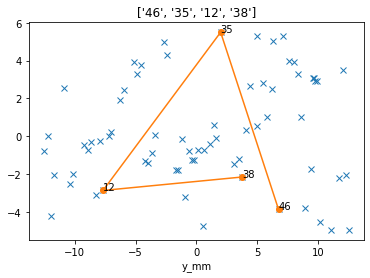

Internal-count,x_mm,y_mm,ra,dec,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
46,6.7589561,-3.858979,32.350896,-5.779373,406.15059970109496,-797.6987999999996,895.1433880440599
35,1.9969477,5.4999202,32.2375,-5.55779,825.2434234417993,712.3644000000013,1090.1787680565526
12,-7.6793793,-2.8581218,32.007183,-5.755669,-977.1719245924241,-60.75359999999961,979.0587163825376
38,3.7831595,-2.1462593,32.279995,-5.738793,0.0,0.0,0.0
38,3.7831595,-2.1462593,32.279995,-5.738793,977.2008927142357,60.75359999999961,979.0876286801192
12,-7.6793793,-2.8581218,32.007183,-5.755669,-824.9611679704386,-712.3644000000013,1089.965121940382
35,1.9969477,5.4999202,32.2375,-5.55779,-406.3065394417599,797.6987999999996,895.2141528788392
46,6.7589561,-3.858979,32.350896,-5.779373,0.0,0.0,0.0


In [8]:
slits = ['46', '51', '14', '8', '12', '16', '38', '44']  #2018
slits = ['46', '51', '19', '8', '12', '10', '38', '43']  # 2022 because 44 and 14 are not visible in 213.9. need to bee thought
# slits = ['46', "51", '35', '12','38']  # 2022 because 44 and 14 are not visible in 213.9. need to bee thought
slits = ['46',  '35', '12','38']  # 2022 because 44 and 14 are not visible in 213.9. need to bee thought
# mask = F1.to_pandas()['Internal-count'].isin(slits)
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

plt.figure()
plt.plot(F1["x_mm"],F1["y_mm"],"x")
plt.plot(selected_slits["x_mm"],selected_slits["y_mm"],"-o")
for s in selected_slits:
    plt.text(s["x_mm"],s["y_mm"],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(slits)
plt.show()

selected_slits = selected_slits['Internal-count',"x_mm","y_mm","ra","dec"]
slit_path = vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path["ra"][:-1] - slit_path["ra"][1:])*np.cos(slit_path["dec"][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path["dec"][:-1] - slit_path["dec"][1:])) + [0]
# slit_path["ra_diff"] = [0] +list((slit_path["ra"][:-1] - slit_path["ra"][1:])*np.cos(slit_path["dec"][1:]*np.pi/180)) 
# slit_path["dec_diff"] = [0] + list((slit_path["dec"][:-1] - slit_path["dec"][1:])) 

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except pd.io.clipboard.PyperclipException:
    pass
slit_path


# selected_slits

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [10]:

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = True, CEg = CEg, Elg = Elg)
moves_tab = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
assert moves.sum(axis=0)[0] <0.1
assert moves.sum(axis=0)[1] <0.1

moves_tab["UV_image"] = moves_tab["UV_image"].astype(bool)
print(moves_tab)
try:
    moves_tab.to_clipboard()
except pd.io.clipboard.PyperclipException:
    pass
print("(They have been copied to clipboard, paste it in the spreadsheet)")

from astropy.table import hstack 
# Table.from_pandas(a[moves_tab["UV_image"]])[2:]
a = moves_tab[moves_tab["UV_image"]]
new_cat = hstack((slit_path,Table.from_pandas(a[moves_tab["UV_image"]])[2:]))

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
try:
    new_cat.to_pandas().to_clipboard()
except pd.io.clipboard.PyperclipException:
    pass
new_cat
# pd.concat([slit_path.to_pandas(), a[1:-1]], axis=1)
# hstack((slit_path,moves_tab[moves_tab["UV_image"]]))

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [1.9969477 5.4999202]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [ 3.7831595 -2.1462593]

targets local coords in siderostat local frame:
EL: 163.5 arcsec ; CE: 374.6 arcsec
EL: 570.2 arcsec ; CE: 172.5 arcsec
EL: 210.6 arcsec ; CE: -245.0 arcsec
EL: 238.5 arcsec ; CE: 247.2 arcsec

siderostat moves sequence: 
            EL          CE  UV_image
0     0.000000  -30.000000     False
1    -0.000000   30.000000      True
2   163.492283  374.561695      True
3   406.714213 -202.032350      True
4  -359.611893 -417.480938      True
5    27.949632  492.121172      True
6    -0.000000   30.000000     False
7     0.000000  -30.000000      True
8   -27.949632 -522.121172     False
9     0.000000   30.000000      True
10  359.611893  417.480938      True
11 -406.714213  232.032350     False
12   -0.000000  -30.000000      True
13 -163.492283 -374.561695      True
(They have b

/tmp/ipykernel_59/1710192623.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_cat = hstack((slit_path,Table.from_pandas(a[moves_tab["UV_image"]])[2:]))
/tmp/ipykernel_59/1710192623.py:22: RuntimeWarning: divide by zero encountered in divide
  new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
/tmp/ipykernel_59/1710192623.py:23: RuntimeWarning: divide by zero encountered in divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/tmp/ipykernel_59/1710192623.py:23: RuntimeWarning: invalid value encountered in divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/tmp/ipykernel_59/1710192623.py:24: RuntimeWarning: divide by zero encountered in divide
  new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]


Internal-count,x_mm,y_mm,ra,dec,ra_diff,dec_diff,angular_distance,EL,CE,UV_image,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64
46,6.7589561,-3.858979,32.350896,-5.779373,406.15059970109496,-797.6987999999996,895.1433880440599,406.71421322607995,-202.03234977146386,True,820.7492822902293,-411.62070942438044,918.1835289346878,1.0257390505234831,-1.028896222847809,-1.0134681808356585
35,1.9969477,5.4999202,32.2375,-5.55779,825.2434234417993,712.3644000000013,1090.1787680565526,-359.6118932707279,-417.4809375668328,True,-725.6968006203288,-850.5756621986651,1118.0853292818392,1.0255981514619252,-1.0187157031153262,-1.0306966866227347
12,-7.6793793,-2.8581218,32.007183,-5.755669,-977.1719245924241,-60.75359999999961,979.0587163825376,27.94963207472453,492.1211723769399,True,56.4023575267941,1002.6476766007773,1004.2328362125575,1.0257125741375697,-0.9283788537106354,-1.0260709004906983
38,3.7831595,-2.1462593,32.279995,-5.738793,0.0,0.0,0.0,0.0,-30.0,True,0.0,-61.122,61.122,inf,nan,-inf
38,3.7831595,-2.1462593,32.279995,-5.738793,977.2008927142357,60.75359999999961,979.0876286801192,0.0,30.0,True,0.0,61.122,61.122,0.06242750721137889,0.0,0.06254803946221321
12,-7.6793793,-2.8581218,32.007183,-5.755669,-824.9611679704386,-712.3644000000013,1089.965121940382,359.6118932707279,417.4809375668328,True,725.6968006203288,850.5756621986651,1118.0853292818392,1.0257991808869966,-1.0187157031153262,-1.031049333256792
35,1.9969477,5.4999202,32.2375,-5.55779,-406.3065394417599,797.6987999999996,895.2141528788392,-0.0,-30.0,True,-0.0,-61.122,61.122,0.06827640046065316,-0.0,0.15043321745197075
46,6.7589561,-3.858979,32.350896,-5.779373,0.0,0.0,0.0,-163.49228312620417,-374.5616953307734,True,-329.92742734868,-763.1319980669176,831.3979515193217,inf,-inf,-inf


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [11]:
slits_coord_obs_det = np.array([
[1420.2,593.9	],
# [?     ,?	],
[2039.1,965.9	],
[1479.7,1706.4	],
[1530.3,826.6	],
[1529.5,825.49511	],
[1479.4,1708.3128	],
[2039.4,966.49409	],
# [?     ,	?	],
[1419.5,594.50322	]])

slit_path["x_det_obs"] = slits_coord_obs_det[:,0]
slit_path["y_det_obs"] = slits_coord_obs_det[:,1]
#TODO should add difference
slit_path
# slit_path.write("/tmp/slit.csv",overwrite=True)



Internal-count,x_mm,y_mm,ra,dec,ra_diff,dec_diff,angular_distance,x_det_obs,y_det_obs
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64
46,6.7589561,-3.858979,32.350896,-5.779373,406.15059970109496,-797.6987999999996,895.1433880440599,1420.2,593.9
35,1.9969477,5.4999202,32.2375,-5.55779,825.2434234417993,712.3644000000013,1090.1787680565526,2039.1,965.9
12,-7.6793793,-2.8581218,32.007183,-5.755669,-977.1719245924241,-60.75359999999961,979.0587163825376,1479.7,1706.4
38,3.7831595,-2.1462593,32.279995,-5.738793,0.0,0.0,0.0,1530.3,826.6
38,3.7831595,-2.1462593,32.279995,-5.738793,977.2008927142357,60.75359999999961,979.0876286801192,1529.5,825.49511
12,-7.6793793,-2.8581218,32.007183,-5.755669,-824.9611679704386,-712.3644000000013,1089.965121940382,1479.4,1708.3128
35,1.9969477,5.4999202,32.2375,-5.55779,-406.3065394417599,797.6987999999996,895.2141528788392,2039.4,966.49409
46,6.7589561,-3.858979,32.350896,-5.779373,0.0,0.0,0.0,1419.5,594.50322


In [12]:
valid = np.isfinite(slits_coord_obs_det[:,0])
#valid = np.array([True]*8 + [False]*8)
# obs_wave = G2UV.mask_det_map.w[0]
try:
    obs_wave = G2UV.mask_det_map.w[0]
except (TypeError, AttributeError) as e:
    obs_wave = 0.2139
    obs_wave = 0.20619 #0.2139
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.20619


### look at siderostat frame hysteresis 

[ 163.49228313  406.71421323 -359.61189327   27.94963207] [  -0.          -27.94963207  359.61189327 -406.71421323]


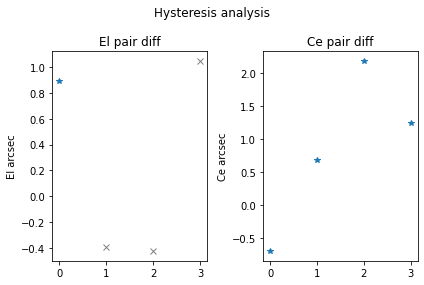

In [31]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs_array = coord_list_to_array(slits_coord_obs)*3600.

mid  = len(slits_coord_obs_array)//2
pair_diff = slits_coord_obs_array[:mid] - slits_coord_obs_array[::-1][:mid]

moves_sign  = np.sign(moves[2:mid+2])
pair_diff_signed = pair_diff * moves_sign

CE_comp = np.nonzero(~flags)[0] + 1
EL = np.delete(moves,CE_comp, axis=0)[:,0]
moves_EL_fwd = EL[1:mid+1]  # skip first to GC
moves_EL_bwd = EL[mid+1:-1] # skip last back to gc
print(moves_EL_fwd, moves_EL_bwd)
moves_EL_opposite = np.sign(moves_EL_fwd)*np.sign(moves_EL_bwd[::-1]) == -1

valid = np.arange(len(moves_sign))#[0,2,3,4]
fig, (ax0,ax1) = plt.subplots(1,2)
ax0.plot(valid[moves_EL_opposite[valid]], pair_diff_signed[moves_EL_opposite[valid], 0],'*')
ax0.plot(valid[~moves_EL_opposite[valid]], pair_diff_signed[~moves_EL_opposite[valid], 0],'x',color='0.5')
ax0.set_title("El pair diff")
ax0.set_ylabel("El arcsec")
ax1.plot(valid, pair_diff_signed[valid, 1],'*')
ax1.set_title("Ce pair diff")
ax1.set_ylabel("Ce arcsec")
fig.suptitle("Hysteresis analysis")
fig.tight_layout()


## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation, translation and magnification
gamma: 1.0066292465414992
theta: -38.08817906911958 arcmin
dx: -2.3858436432978016 arcsec
dy: -115.59492681107602 arcsec
variances: [6.16320729e-04 2.11875459e+00 5.38517430e-01 5.38517430e-01]

residuals in arcsec: [[ 2.70799792 -0.41186526]
 [-1.46909364 -2.97205219]
 [-0.84219775  0.42359429]
 [ 0.59415742  1.80271605]
 [-0.45654265  0.56486038]
 [-1.26968476  2.60500545]
 [-1.07586554 -2.29619176]
 [ 1.81122899  0.28393303]]
max residual in EL,CE 2.7, 3.0 arcsec
mean residual in EL,CE 1.4, 1.8 arcsec


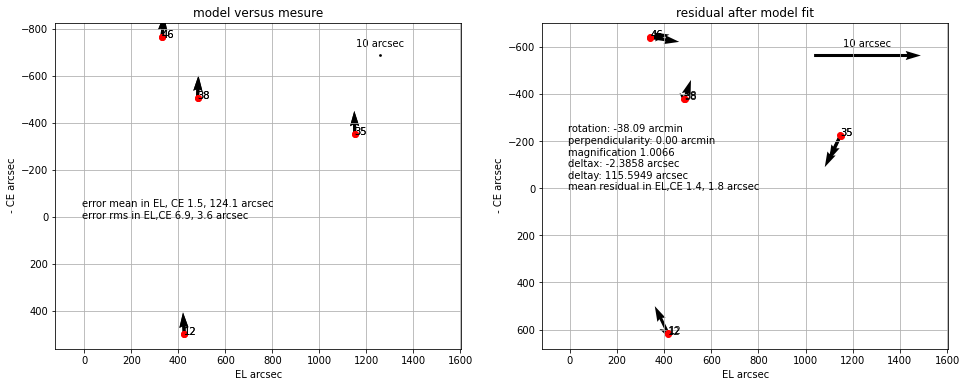

After updating:
    mask_rotation: -58.64511674999432 arcmin
    FOV center in guider: 1378.693979871479 x 218.86229256720372 pix = 671.0685965047752 arcsec x -298.25199079667595 arcsec arcsec
    mask_magnification correction: 1.0324778102105137  
    


In [33]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
#weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, labels=slits_valid, plot=True, figsize=(16,6))


### check updating without fitting magnification

In [37]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: -20.55693768087474 arcmin
    FOV center in guider: 1377.2359789722852x352.9709380356972 pix



Fitting rotation, translation and magnification
gamma: 1.0066292465414992
theta: -38.08817906911958 arcmin
dx: -2.3858436432978016 arcsec
dy: -115.59492681107602 arcsec
variances: [6.16320729e-04 2.11875459e+00 5.38517430e-01 5.38517430e-01]

residuals in arcsec: [[ 2.70799792 -0.41186526]
 [-1.46909364 -2.97205219]
 [-0.84219775  0.42359429]
 [ 0.59415742  1.80271605]
 [-0.45654265  0.56486038]
 [-1.26968476  2.60500545]
 [-1.07586554 -2.29619176]
 [ 1.81122899  0.28393303]]
max residual in EL,CE 2.7, 3.0 arcsec
mean residual in EL,CE 1.4, 1.8 arcsec


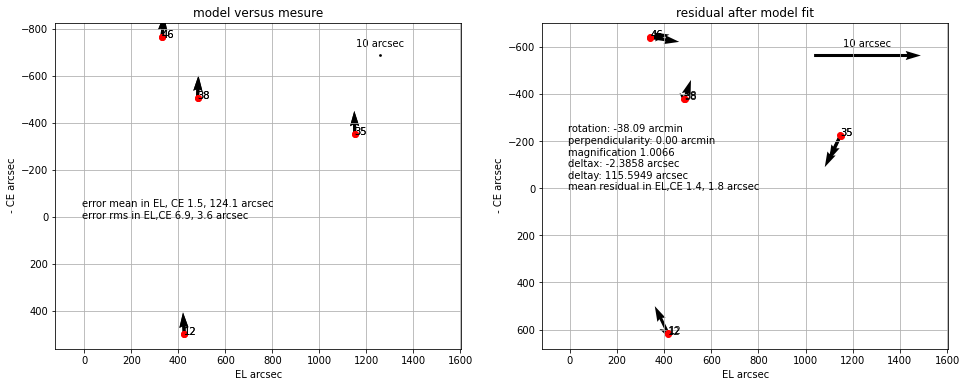

After updating:
    mask_rotation: -58.64511674999432 arcmin
    FOV center in guider: 1378.693979871479 x 218.86229256720372 pix = 671.0685965047752 arcsec x -298.25199079667595 arcsec arcsec
    mask_magnification correction: 1.0066292465414992  
    


In [46]:
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits_valid, plot=True, figsize=(16,6), gamma=True)


### save corrected model for future use (eg redo the clalib on same field)

In [15]:
G2UVcor.save(filename="Calibration/Mappings/2022/XY/%s_XY_%s.pkl"%(Field,datetime.datetime.now().strftime("%y%m%d")))

Dumping to Calibration/Mappings/2022/XY/F1_XY_220715.pkl


### plot corrected positions vs real source positions on sky

we should do this computation from observed positions after correction (this notebook does not have them...)

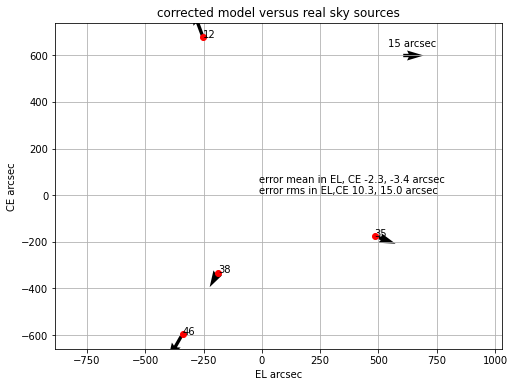

In [40]:
slit_coords, source_coords = G2UVcor.compare_mask_2_sky(slits, F1, slits_valid)

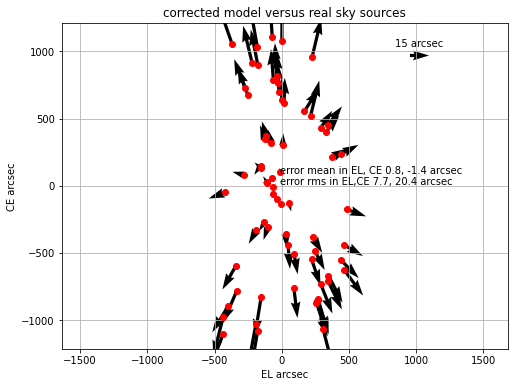

In [47]:
slit_coords_all, source_coords_all = G2UVcor.compare_mask_2_sky(F1['Internal-count'], F1)

since done with computed positions => the mask was not burned with the polynomial magnification ? 

## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [16]:
# moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = True, CEg = CEg/2, Elg = Elg/2)
CEg

1.0187

In [17]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = True, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print(moves)
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]
moves["UV_image"] = moves["UV_image"].astype(bool)
new_cat = hstack((slit_path,moves[moves["UV_image"]][1:-1]))
new_cat
new_cat["EL_moves"] =  list(new_cat["EL_abs"][1:] - new_cat["EL_abs"][:-1]) +  [0]
new_cat["CE_moves"] =  list(new_cat["CE_abs"][1:] - new_cat["CE_abs"][:-1]) +  [0]



new_cat["El_sky"] = new_cat["EL_moves"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE_moves"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
try:
    new_cat.to_pandas().to_clipboard()
except pd.io.clipboard.PyperclipException:
    pass
new_cat["ra_diff","dec_diff","EL_moves","CE_moves","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit position in mm on mask: [1.9969477 5.4999202]
slit position in mm on mask: [-7.6793793 -2.8581218]
slit position in mm on mask: [ 3.7831595 -2.1462593]

targets local coords in siderostat local frame:
EL: 159.2 arcsec ; CE: 435.6 arcsec
EL: 570.9 arcsec ; CE: 236.7 arcsec
EL: 213.6 arcsec ; CE: -187.6 arcsec
EL: 236.2 arcsec ; CE: 308.2 arcsec

siderostat moves sequence: 
         EL                  CE         UV_image
------------------- ------------------- --------
                0.0               -30.0      0.0
               -0.0                30.0      1.0
 159.17142494186535   435.5824518302165      1.0
  411.7123620697076 -198.89247504355012      1.0
-357.31913572306104  -424.2487289951883      1.0
  22.59566130544495   495.7251229379478      1.0
               -0.0                30.0      0.0
                0.0               -30.0      1.0
 -22.59566130544495  -525.7251229379478      0.0
                0.0         

/tmp/ipykernel_326/3904656778.py:18: RuntimeWarning: invalid value encountered in divide
  new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
/tmp/ipykernel_326/3904656778.py:19: RuntimeWarning: invalid value encountered in divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/tmp/ipykernel_326/3904656778.py:20: RuntimeWarning: invalid value encountered in divide
  new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]


ra_diff,dec_diff,EL_moves,CE_moves,El_sky,Cel_sky,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
float64,float64,float64,float64,float64,float64,float64,float64,float64
406.15059970109496,-797.6987999999996,411.71236206970764,-198.89247504355012,830.83554665667,-405.223528653729,1.0326706962247094,-1.0415404243514852,-0.9977174204641129
825.2434234417993,712.3644000000013,-357.31913572306104,-424.2487289951883,-721.0700158891372,-864.3643604547966,1.032528845008387,-1.0122207340641052,-1.047405330235578
-977.1719245924241,-60.75359999999961,22.595661305444935,495.7251229379478,45.59804451438787,1009.9903654737748,1.0326440409191109,-0.7505406184059573,-1.0335851246391867
0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
977.2008927142357,60.75359999999961,-22.595661305444935,-495.72512293794784,-45.59804451438787,-1009.9903654737749,1.032613547109433,-0.7505406184059573,-1.033554485064442
-824.9611679704386,-712.3644000000013,357.31913572306104,424.2487289951883,721.0700158891372,864.3643604547966,1.0327312329317524,-1.0122207340641052,-1.0477636936309345
-406.3065394417599,797.6987999999996,-411.7123620697076,198.89247504355012,-830.8355466566699,405.223528653729,1.0325890657333183,-1.041540424351485,-0.9973344982595679
0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence 
gc - s8 - s25 - s31

In [18]:
star_target_path = "Calibration/Targets/2022/GuidingStars/F1_guidingstars.fits"

F1_stars = Table.read(star_target_path, format='fits').to_pandas()

stars = [8, 25, 31]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = True, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])

stars_path = vstack((selected_stars,selected_stars[::-1]) )
selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    star_moves.to_clipboard()
except pd.io.clipboard.PyperclipException:
    pass
star_moves




targets local coords in siderostat local frame:
EL: 159.5 arcsec ; CE: -12.3 arcsec
EL: 173.7 arcsec ; CE: 199.1 arcsec
EL: 103.6 arcsec ; CE: 256.0 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,Image
0,-0.000000,30.000000,0.0
1,0.000000,-30.000000,1.0
2,159.486089,-12.335620,1.0
3,14.208728,211.416989,1.0
4,-70.134723,56.899110,1.0
5,-0.000000,30.000000,0.0
6,0.000000,-30.000000,1.0
7,70.134723,-56.899110,1.0
8,-14.208728,-241.416989,0.0
9,0.000000,30.000000,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [19]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
try:
    selection.to_pandas().to_clipboard()
except pd.io.clipboard.PyperclipException:
    pass
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
8,32.1014,-5.786504,-3.751016,-4.191964,11,11,11,954.7166340246686,952.1343510310977
25,32.221491,-5.776507,1.333233,-3.766303,9,--,--,990.2173692400569,476.91827039575276
31,32.254526,-5.815258,2.731668,-5.415391,--,12,12,836.6074480025399,344.4301880821129
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------